In [1]:

import quimb.tensor as qtn
import quimb as qu
from quimb import randn
import numpy as np
from quimb.tensor.optimize import TNOptimizer
from quimb.tensor.optimize import NADAM

In [57]:

def add_su4_circ(q1,q2,params):
    """
    inputs:
        - q1,2 qubits
        - params, qiskit ParameterVector object or list of qk Parameters
    returns: 
        - QKParamCircuit object
    """
    circ = qtn.Circuit(N=2)
    param1 = params[:3]
    param2 = params[3:6]
    param3 = params[6:7]
    param4 = params[7:8]
    param5 = params[8:9]
    param6 = params[9:12]
    param7 = params[12:15]
    
    circ.apply_gate('U3', *param1, q1,
            gate_round=None, parametrize=True)
    circ.apply_gate('U3', *param2, q2,
            gate_round=None, parametrize=True)    
    circ.apply_gate('CX', q1, q2,
            gate_round=None,parametrize=False)        
    circ.apply_gate('RZ', *param3, q1,
            gate_round=None,parametrize=True)
    circ.apply_gate('RY', *param4, q2,
            gate_round=None,parametrize=True)
    circ.apply_gate('CX', q1, q2,
            gate_round=None,parametrize=False)        
    circ.apply_gate('RY', *param5, q2,
            gate_round=None,parametrize=True)    
    circ.apply_gate('CX', q1, q2,
            gate_round=None,parametrize=False)
    circ.apply_gate('U3', *param6, q1,
            gate_round=None, parametrize=True)
    circ.apply_gate('U3', *param7, q2,
            gate_round=None, parametrize=True)
    return circ

def MPDO(circuit,dm,n,j):
    """
    Constructs the Matrix Product Density Operator
    """
    k = circuit
    k = k.reindex({'k0':f'p{j}', 'k1':f'b{n+1}', 'b0':f'p{j+1}', 'b1':f'b{n}'})
    
    dm1 = dm.reindex({'b1':f'p{j+1}','kc0':f'p{j+2}'})

    kc = circuit.H
    #kc = kc.reindex({'k0':f'bx{n}','k1':f'bx{n+1}','b0':f'p{j+2}','b1':f'p{j+3}'})
    kc = kc.reindex({'k0':f'p{j+3}','k1':f'bx{n+1}','b0':f'p{j+2}','b1':f'bx{n}'})
    
    TN = k & dm1 & kc  
    return TN

def contract(circuit,dm,N,state_vcl):
    """
    Returns tensor contractions (for density matrix)
    """
    TN_list = [MPDO(circuit,dm,n,j) for n,j in zip(range(N),range(0,4*N+6,5))]
    
    # boundary conditions
    # for ket:
    inds0 = 'b0',
    s_left = qtn.Tensor(state_vcl,inds0,tags='sl')
    
    inds1 = f'b{N}',f'bx{N}',
    s_right = qtn.Tensor(np.eye(state_vcl.size),inds1,tags='rvec')

    # for bra:
    inds2 = 'bx0',
    sc_left = qtn.Tensor(state_vcl.conj(),inds2,tags='scl')
    
    # tenor contractions
    TN0 = TN_list[0]
    for j in range(1,len(TN_list)):
        TN0 = TN_list[j] & TN0
    
    TN = s_left & s_right & sc_left & TN0
    return TN

def pre_meas(params):
    '''
    A circuit to prepare unitary circuit that we use for density operator
    '''
    circ = qtn.Circuit(2)
    circ.apply_gate('RY', *params, 0,
            gate_round=None,parametrize=True)
    circ.apply_gate('CNOT',0,1,
            gate_round=None,parametrize=False)
    return circ

def density_matrix(unitary_circ):
    '''
    Here we prepare the density matrix
    '''
    a = unitary_circ.uni
    ini = np.zeros([4,4])
    ini[0][0]=1
    ini = ini.reshape(2,2,2,2)
    ind = 'k0','k1','bc0','bc1'
    den = qtn.Tensor(ini,ind,tags='den')
    b = a.reindex({'b1':'k0','b0':'k1','k0':'b1','k1':'b0'})
    b = b.reindex({'k0':'bc0','k1':'bc1','b0':'kc0','b1':'kc1'})
    TN = a & den & b
    TN = TN.reindex({'b0':'x','kc1':'x'})
    return TN

In [86]:

# params
T = 2
l_uc = 1
L = 2
N = L * l_uc
jz = -1
bx = -2
state_vcl = np.array([1.,0.])

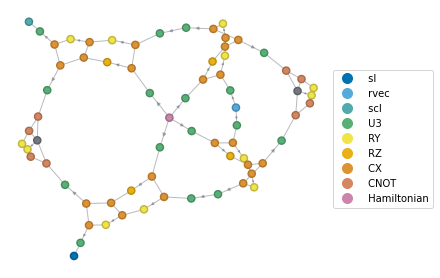

In [87]:

import quimb as qu

# hamiltonian
U_dense = qu.ham_ising(N, jz=jz, bx=bx, cyclic=True)

if N < 5:
    k = 0
elif 5 <= N < 10:
    k = 5
elif N == 10:
    k = 10
    
U = qtn.Tensor(
    data=U_dense.reshape([2] * (2 * N)),
    inds=[f'p{j+3}' for j in range(0,4*N+k,5)] + [f'p{j}' for j in range(0,4*N+k,5)],
    tags={'Hamiltonian'}
)

param = qu.randn(16, dist='uniform')
circuit = add_su4_circ(0,1,param[1:]).uni
dm = density_matrix(pre_meas(param[:1]))
V = contract(circuit,dm,L,state_vcl)

def loss(V,U):
    return np.real((V & U).contract(all, optimize='auto-hq',backend = 'jax'))

(U & V).draw(color=['sl','rvec','scl','U3','RY','RZ','CX','CNOT','Hamiltonian'])

In [88]:

tnopt = TNOptimizer(
    V,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U},  # supply U to the loss function as a constant TN
    autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='tnc',     # the optimization algorithm
    tags=['RY','U3','RZ']
)
v_opt = tnopt.optimize(1000,tol=1e-10,jac=True)

-1.999997854233 [best: -1.999998331070] : : 1001it [00:05, 194.28it/s]                        


In [89]:

# dmrg computations
from quimb import *
from quimb.tensor import *
H = MPO_ham_ising(N, j=jz, bx=bx)
DMRG2(H).solve(max_sweeps=100, verbosity=1, cutoffs=1e-6)

SWEEP-1, direction=R, max_bond=(8/8), cutoff:1e-06


100%|############################################| 1/1 [00:00<00:00, 535.19it/s]

Energy: -2.0155644370746364 ... not converged.
SWEEP-2, direction=R, max_bond=(2/16), cutoff:1e-06



100%|############################################| 1/1 [00:00<00:00, 520.13it/s]

Energy: -2.0155644370746364 ... converged!


True